# DEPENDENCIES FOR BNN USING HMC
**Abbreviations**:

- ANN: Artificial Neural Network
- BNN: Bayesian Neural Network
- HMC: Hamiltonian Monte Carlo

# Necessary Imports

In [1]:
import keras
import tensorflow_probability as tfp
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# To handle statistical distributions:
tfd = tfp.distributions

# Loading the predefined synthetic regression problems:
import import_ipynb
N = import_ipynb.NotebookLoader(path=['.'])
N.load_module('dependencies_for_data_generation')
from dependencies_for_data_generation import *




importing Jupyter notebook from .\dependencies_for_data_generation.ipynb


# Class for Wrapping Functional Model

In [2]:
class FunctionalModel:
    def __init__(self, lr=0.01):
        # BUILD MODEL TOPOLOGY
        
        self.model = keras.Sequential([
            keras.layers.Input((1,)),                   # Input (single dimension)
            keras.layers.Dense(100, activation='relu'), # Hidden layer
            keras.layers.Dense(1)])                     # Output layer, with linear activation
        
        #------------------------------------
        # COMPILING MODEL WITH APPROPRIATE LOSS AND OPTIMIZER
    
        # Optimizer:
        optimizer = keras.optimizers.Adam(learning_rate=lr)
        # Loss function:
        loss = keras.losses.MeanSquaredError()
        # Compiling the model:
        self.model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

        #------------------------------------
        # INITIALISING MODEL WEIGHTS
        
        self.model_weights = self.model.get_weights()
        # NOTE 1: This is done in case the `self.fit` was not run before HMC sampling
        # NOTE 2: The reason for storing weights like this is given in the implementation note below this code block

    #================================================
    # WRAPPER FUNCTION FOR MODEL FITTING
    
    def fit(self, x, y, epochs=30, batch_size=2, verbose=False):
        # Returning the return value of the predefined fit function based on given arguments:
        self.model.fit(x, y, epochs=30, batch_size=2, verbose=False)
        # Storing the model weights to be used later (see the implementation note below this code block):
        self.model_weights = self.model.get_weights()

    #================================================
    # WRAPPER FUNCTION FOR MODEL SUMMARISATION
    
    def summary(self):
        return self.model.summary()

    #================================================
    # WRAPPER FUNCTION FOR MODEL PREDICTION
    def predict(self, x):
        return self.model.predict(x)

    #================================================
    # FUNCTION TO OBTAIN PREDICTIONS FOR PROPOSED PARAMETER VALUES
    
    def predict_for_proposal(self, x_data, θ):
        model_weights_copy = [] # To preserve the original model weights for easy re-running of sampling loop
        for model_weights_layer in self.model_weights:
            model_weights_copy.append(model_weights_layer)
        model_weights_copy[1] = θ
        self.model.set_weights(model_weights_copy)
        model_predictions = self.model(x_data)
        return model_predictions

**IMPLEMENTATION NOTE: Why store the weights and not simply call `model.get_weights` later?**

When within the HMC sampling loop, as per the implementation we are using, I experienced complications when trying to call `model.get_weights` in the function `predict_for_proposal` (defined above). Based on what I understood, `model.get_weights` relies on the use of Tensor-to-NumPy conversion, but it turns out that to do such a conversion within the sampling loop requires certain settings. In particular, I received the following error:

```
NotImplementedError: numpy() is only available when eager execution is enabled.
```

Maybe a possible solution is to enable eager execution within the model, using `model.run_eagerly = True`, but I prefer to assign the weights array beforehand and just use that array, for the sake of simplicity.

# Global Variables and Functions
The following variables and functions need to be defined globally to conveniently use the HMC sampler defined in `tensorflow_probability`.

---

**Variables/data**:

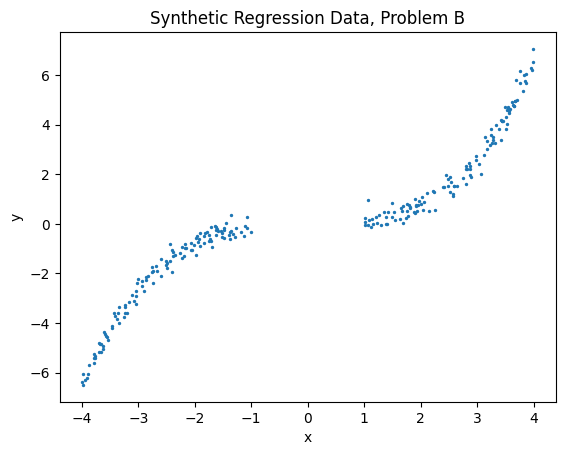

In [3]:
# FUNCTIONAL MODEL
functional_model = FunctionalModel()

#================================================
# DICTIONARY OF HYPERPARAMETERS FOR THE DISTRIBUTIONS

hyperparams = {'layer':1, 'σ': 2, 'τ': 2}
'''
layer : The network layer for which the posterior must be sampled
σ     : Standard deviation for the prior distribution (i.e. assumed scale of the model parameters)
τ     : Standard deviation for the likelihood distribution (i.e. scale of the error terms)
'''

#================================================
# DATA

# Initialising data variables by generating a synthetic problem's data:
x_train, y_train, x_test, y_test = None, None, None, None
if __name__ == '__main__':
    x_train, y_train, x_test, y_test = generate_data('B')
else:
    x_train, y_train, x_test, y_test = generate_data('B', visualise_problem=False)

**Functions**:

In [4]:
# MAKING THE PRIOR DISTRIBUTION

def make_prior(dims, σ):
        return tfd.MultivariateNormalDiag(loc=tf.zeros([dims]), scale_diag=σ*tf.ones([dims]))

#================================================
# MAKING THE LIKELIHOOD DISTRIBUTION

def make_likelihood(θ, x_data, τ):
    '''
    Calculate the likelihood of the data given the parameters
    ------------------------------------
    INPUT
    θ         : Vector of parameters
    x_data    : Data on which to make the prediction
    τ_squared : Variance of the error term
    '''
    
    # First make a prediction with parameters θ:
    functional_model_prediction = functional_model.predict_for_proposal(x_data, θ) # = f_θ(x), i.e. output of the model parametrised by θ, without error

    # Return the likelihood distribution:
    return tfd.Normal(loc=functional_model_prediction, scale=τ*tf.ones_like(functional_model_prediction))

#================================================
# RETURNING THE UNNORMALISED LOG-PROBABILITY OF THE POSTERIOR

def unnormalized_log_prob(θ):
    prior = make_prior(dims=θ.shape[0], σ=hyperparams['σ'])
    likelihood = make_likelihood(θ, x_train, hyperparams['τ'])
    p = prior.log_prob(θ) + tf.reduce_sum(likelihood.log_prob(y_train))
    return p

# Class for Wrapping HMC Sampler

In [5]:
class HMC:
    def __init__(self, num_burnin_steps=5000, num_results=10000, num_leapfrog_steps=3, step_size=1.):
        # Setup assumptions:
        self.num_burnin_steps = num_burnin_steps
        self.num_results = num_results # Number of samples to draw
        self.num_leapfrog_steps = num_leapfrog_steps # Number of leapfrog steps from the initial position before proposing a sample
        self.step_size = step_size # Size of each leapfrog step
        self.initialise_kernel()

        # Initial position/state of the sampler:
        self.initial_state = tf.constant(functional_model.model_weights[hyperparams['layer']]) # Initial position of the sampler

    #================================================
    # INITIALISING TRANSITION KERNEL
    
    def initialise_kernel(self):
        # Defining an simple step size adaptation transition kernel (explained in the notes below):
        self.kernel = tfp.mcmc.SimpleStepSizeAdaptation(
            # The HMC transition kernel is wrapped within the simple step size adaptation transition kernel:
            tfp.mcmc.HamiltonianMonteCarlo(
                target_log_prob_fn=unnormalized_log_prob,
                num_leapfrog_steps=self.num_leapfrog_steps,
                step_size=self.step_size),
            num_adaptation_steps=int(self.num_burnin_steps*0.8))

    #================================================
    # FUNCTION TO RUN THE MARKOV CHIAN SAMPLER
    
    @tf.function(reduce_retracing=True) # This decorator is explained in the notes below
    def run_chain(self):
        # Run the chain (with burn-in).
        samples, is_accepted = tfp.mcmc.sample_chain(
            num_results=self.num_results,
            num_burnin_steps=self.num_burnin_steps,
            current_state=self.initial_state,
            kernel=self.kernel,
            trace_fn=lambda _, pkr: pkr.inner_results.is_accepted)
    
        # Returning the summary statistics of the samples as well as the samples themselves:
        return samples

**IMPLEMENTATION NOTE: `@tf.function` decorator**:

A tf.function that you define (for example by applying the @tf.function decorator) is just like a core TensorFlow operation: You can execute it eagerly; you can compute gradients; and so on.

> **Reference**: [Better performance with `tf.function` (Tensorflow documentation)](https://www.tensorflow.org/guide/function)

---

**CONCEPTUAL NOTE: Transition kernel (a.k.a. Markov kernel)**:

A transition kernel in this context refers to a Markov kernel and pertains to a given Markov chain (note that "Markov chain" = "Markov process"). A transition kernel of a Markov chain is a function that defines the transitions of the Markov chain. Specificallly, it defines the transition probabilities between states in the Markov chain (as a side note, it is a generalisation of the transition matrix in finite state Markov chains).

> **Reference**: [_Markov kernel_, **Wikipedia**](https://en.wikipedia.org/wiki/Markov_kernel)

---

**TECHNICAL NOTE: `tensorflow_probability.mcmc.TransitionKernel`**:

The base class for all MCMC transition kernels (defined above). This class defines the minimal requirements to efficiently implement a Markov chain Monte Carlo (MCMC) transition kernel. A transition kernel returns a new state given some old state (as a side note, it also takes and returns additional information which may be used for (a) debugging or (b) optimisation purposes, i.e, to "recycle" previously computed results).

> **Reference**: [`tfp.mcmc.TransitionKernel` (Tensorflow documentation)](https://www.tensorflow.org/probability/api_docs/python/tfp/mcmc/TransitionKernel)

---

**IMPLEMENTATION NOTE: `tensorflow_probability.mcmc.SimpleStepSizeAdaptation`**:

It is a subclass of `tensorflow_probability.mcmc.TransitionKernel` that uses a simple policy to adapt the inner kernel's `step_size`, i.e. the size of each transition step from the current state to a proposal state), based on `log_accept_prob`, i.e. the logarithm of the Metropolis acceptance probability (note that logarithms are used since they are more numerically conservative and hence help avoid arithmetic overflow). More precisely, it multiplicatively increases or decreases the `step_size` of the inner kernel based on the value of `log_accept_prob`.

> **Reference**: [`tfp.mcmc.SimpleStepSizeAdaptation` (Tensorflow documentation)](https://www.tensorflow.org/probability/api_docs/python/tfp/mcmc/SimpleStepSizeAdaptation)

---

**TECHNICAL NOTE: `tfp.mcmc.HamiltonianMonteCarlo`**:

`tfp.mcmc.HamiltonianMonteCarlo` is a subclass of `tensorflow_probability.mcmc.TransitionKernel`, just as HMC is a subclass of MCMC.

# Training the Model as a Traditional ANN

In [8]:
if __name__ == '__main__':
    functional_model.fit(x_train, y_train, epochs=30, batch_size=2, verbose=False)

Plotting the results (plotting functions packaged as a function for reusability)...

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  


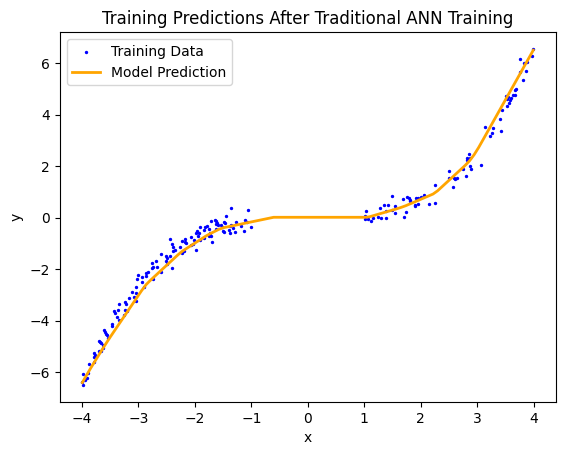

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


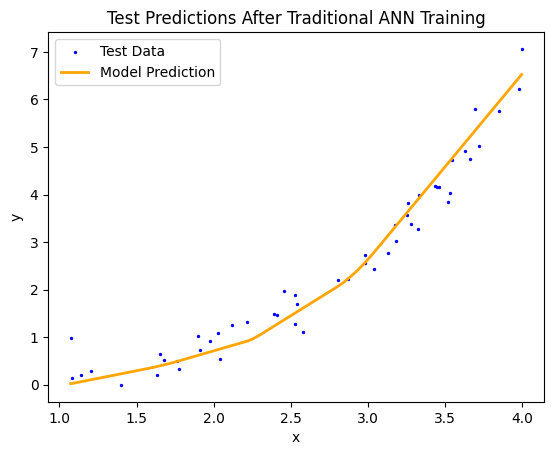

In [9]:
# Function to plot training results:
def plot_ann_training_results(show_train_results=True, show_test_results=True):
    # Plotting the training data with predictions:
    if show_train_results:
        # Plotting the test data:
        plt.scatter(x_train, y_train, s=2, color='blue', label='Training Data') 
        
        # Obtaining and plotting predictions for the training range:
        x = np.linspace(min(x_train), max(x_train), 100)
        y_predict = functional_model.predict(x)
        plt.plot(x, y_predict, linewidth=2, color='orange', label='Model Prediction')
        
        # Final formatting for the plot:
        plt.title('Training Predictions After Traditional ANN Training')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.legend()
        plt.show()

    #------------------------------------
    # Plotting the test data with predictions:
    if show_test_results:
        # Plotting the test data:
        plt.scatter(x_test, y_test, s=2, color='blue', label='Test Data') 
        
        # Obtaining and plotting predictions for the testing range:
        x = np.linspace(min(x_test), max(x_test), 100)
        y_predict = functional_model.predict(x)
        plt.plot(x, y_predict, linewidth=2, color='orange', label='Model Prediction')
        
        # Final formatting for the plot:
        plt.title('Test Predictions After Traditional ANN Training')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.legend()
        plt.show()

if __name__ == '__main__':
    plot_ann_training_results()

# Sampling From Posterior of Model Parameters
Note that here, we are only sampling from the posterior of the second layer of weights; all other weights are kept constant.

In [16]:
# Defining the storage variables in the global scope:
if __name__ == '__main__':
    hmc = HMC(num_burnin_steps=5000, num_results=10000, num_leapfrog_steps=5, step_size=1.)
    samples = hmc.run_chain()

Plotting the results...

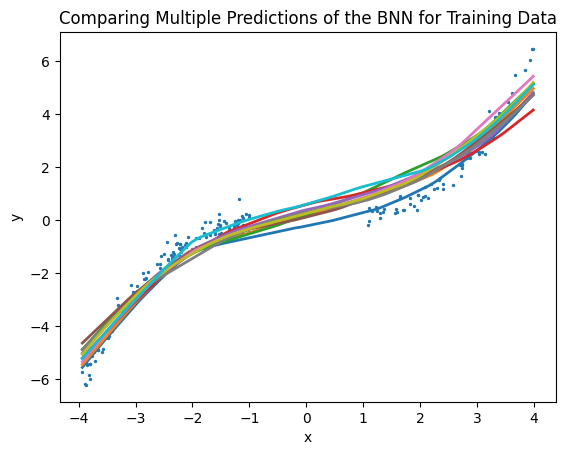

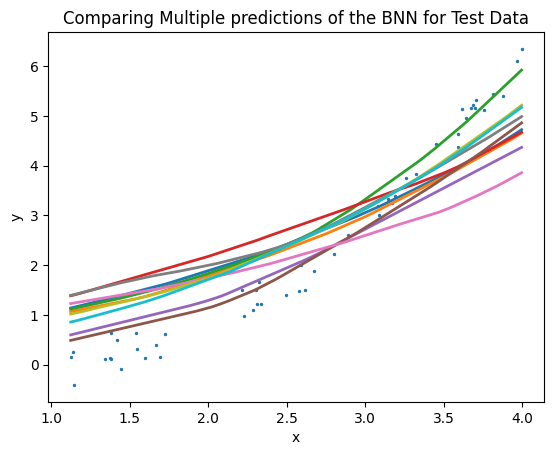

In [19]:
def plot_hmc_results(samples, samples_to_show=3, show_train_results=True, show_test_results=True, show_labels=True):
    if show_train_results:
        # Plotting the training data:
        plt.scatter(x_train, y_train, s=2, label='Training Data')

        # Obtaining and plotting multiple predictions:
        x = np.linspace(min(x_train), max(x_train), 100)
        for i in range(samples_to_show):
            # Picking a random sample:
            random_sample = samples[np.random.choice(samples.shape[0])]
            # Prediction according to the parametrisation based on the above sample:
            y_predict = functional_model.predict_for_proposal(x, random_sample)
            # Plotting the prediction:
            plt.plot(x, y_predict, linewidth=2, label=f'Prediction {i+1}')
        
        # Final formatting for the plot:
        plt.title('Comparing Multiple Predictions of the BNN for Training Data')
        plt.xlabel('x')
        plt.ylabel('y')
        if show_labels:
            plt.legend()
        plt.show()
        
    #------------------------------------
    if show_test_results:
        # Plotting the test data:
        plt.scatter(x_test, y_test, s=2, label='Test Data') 
        
        # Obtaining and plotting multiple predictions:
        x = np.linspace(min(x_test), max(x_test), 100)
        for i in range(samples_to_show):
            # Picking a random sample:
            random_sample = samples[np.random.choice(samples.shape[0])]
            # Prediction according to the parametrisation based on the above sample:
            y_predict = functional_model.predict_for_proposal(x, random_sample)
            # Plotting the prediction:
            plt.plot(x, y_predict, linewidth=2, label=f'Prediction {i+1}')
        
        # Final formatting for the plot:
        plt.title('Comparing Multiple predictions of the BNN for Test Data')
        plt.xlabel('x')
        plt.ylabel('y')
        if show_labels:
            plt.legend()
        plt.show()

if __name__ == '__main__':
    plot_hmc_results(samples, samples_to_show=10, show_labels=False)